In [1]:
import cv2, numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Load Parameters

In [2]:
from utils import read_json

params = read_json('parameters.json')

RESIZE_X = params['resize']['x']
RESIZE_Y = params['resize']['y']
ITEM_FOLDER = params['item_folder']

## Input Data
* Image of the bin
* List of items in the bin

In [3]:
bin_stamp = '170405145336'
contents = ["Colgate_Toothbrush_4PK","Epsom_Salts","Duct_Tape",
            "Bath_Sponge","Crayons","Burts_Bees_Baby_Wipes"]

In [3]:
bin_stamp = '170405145538'
contents = ["glue_sticks","tissue_box","laugh_out_loud_jokes",
            "toilet_brush","expo_eraser","table_cloth"]

In [4]:
contents = [s.lower() for s in contents]

## Phase 1: Recognition by SIFT Features
### Compute Features in Bin

1183 features detected


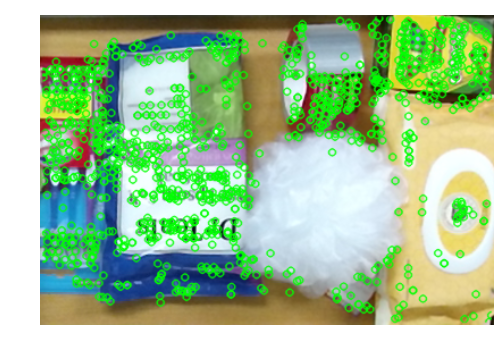

In [5]:
from utils import imread_rgb, compute_sift

filename_bin = 'bin/' + bin_stamp + '.png'
image_bin = imread_rgb(filename_bin)
(kp_bin, des_bin) = compute_sift(image_bin)

### Match Bin and Items Features

Item: "Training_items/colgate_toothbrush_4pk/colgate_toothbrush_4pk_top_01_sift.npy" Good features: 12
Item: "Training_items/epsom_salts/epsom_salts_top_01_sift.npy" Good features: 55
Item: "Training_items/duct_tape/duct_tape_top_01_sift.npy" Good features: 2
Item: "Training_items/bath_sponge/bath_sponge_top_01_sift.npy" Good features: 5
Item: "Training_items/crayons/crayons_top_01_sift.npy" Good features: 38
Item: "Training_items/burts_bees_baby_wipes/burts_bees_baby_wipes_top_01_sift.npy" Good features: 10


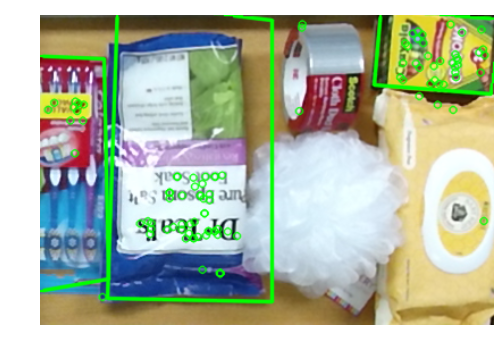

In [6]:
from utils import match_items

items = list(contents)
item_d, recognised_items, mask_items = match_items(image_bin, kp_bin, des_bin, items)

### Not recognised items

In [7]:
items = [s for s in contents if s not in recognised_items]
items

['duct_tape', 'bath_sponge', 'burts_bees_baby_wipes']

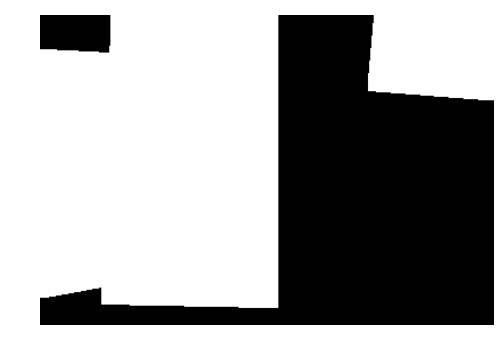

In [8]:
kernel = np.ones((3,3),np.uint8)
mask_items = cv2.dilate(mask_items,kernel,iterations = 5)
plt.imshow(mask_items,cmap='gray'), plt.axis('off');

## Phase 2: segment bin by depth into upper / lower levels

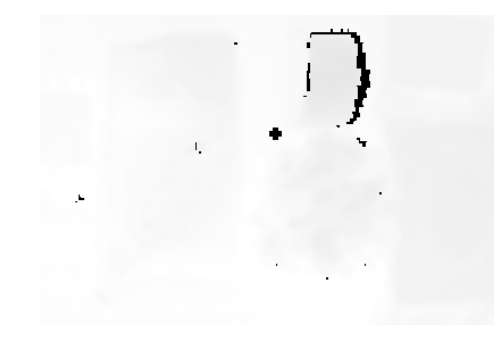

In [9]:
from utils import imread_gray
filename_bin = 'bin/' + bin_stamp + '.pgm'
image_depth = imread_gray(filename_bin)
plt.imshow(image_depth,cmap='gray'); plt.axis('off');

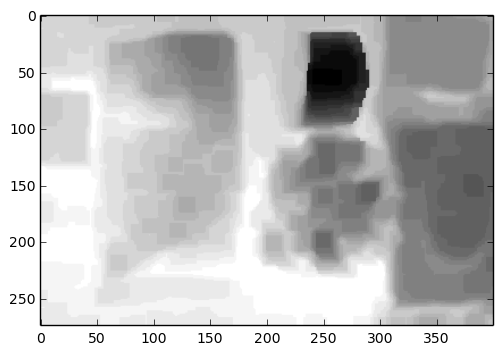

In [10]:
from utils import fill_holes

image_depth = fill_holes(image_depth)
plt.imshow(image_depth,cmap='gray');

In [48]:
min_depth = int(np.min(image_depth))
thresh_depth = min_depth + 1
stop = False
while not stop:
    top_obj = cv2.inRange(image_depth,min_depth,thresh_depth)
    top_obj = cv2.bitwise_and(top_obj, top_obj, mask=255-mask_items)
    (cnt,_) = cv2.findContours(top_obj,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if len(cnt)>0:
        #max_cnt = max(cnt, key = cv2.contourArea)
        #stop = (cv2.contourArea(max_cnt) > 10000)
        cnt = sorted(cnt, key = cv2.contourArea, reverse=True)
        stop = (cv2.contourArea(cnt[0]) > 20000)
    thresh_depth += 1
max_cnt = cnt[1]

In [49]:
item_mask = np.zeros(top_obj.shape,dtype='uint8')
cv2.drawContours(item_mask,[max_cnt],-1,(255,),-1)
image_top = cv2.bitwise_and(image_bin,image_bin,mask=item_mask)

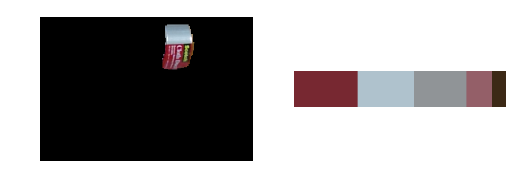

In [50]:
from utils import compute_colors, plot_colors

h_obj, cc_obj = compute_colors(image_bin, item_mask)
plt.subplot(121); plt.imshow(image_top); plt.axis('off');
bar = plot_colors(h_obj, cc_obj)
plt.subplot(122); plt.imshow(bar); plt.axis('off');

In [51]:
import glob
import json
dc_list = []
for item in items:
    folder = 'Training_items/' + item + '/'
    files = glob.glob(folder + '*_dc.json')
    for filename in files:
        with open(filename) as data_file:
            dominant_colors = json.load(data_file)
        dc_list.append((filename,dominant_colors))

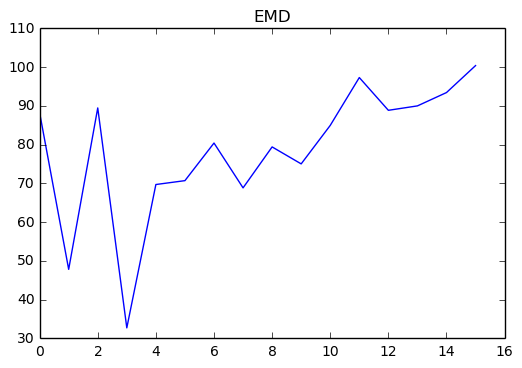

32.73 duct_tape/duct_tape_top-side_01
47.83 duct_tape/duct_tape_bottom-side_01
68.86 bath_sponge/bath_sponge_top_01
69.72 bath_sponge/bath_sponge_top-side_01
70.72 bath_sponge/bath_sponge_top-side_02
75.05 bath_sponge/bath_sponge_bottom-side_02
79.43 bath_sponge/bath_sponge_bottom-side_01
80.43 bath_sponge/bath_sponge_bottom_01
84.98 burts_bees_baby_wipes/burts_bees_baby_wipes_bottom-side_01
88.25 duct_tape/duct_tape_bottom_01


In [52]:
from utils import calc_EMD2

ddc = []
refdc = []
for name, dc in dc_list:
    h_ref = dc['hist']
    cc_ref = dc['cluster_centers']
    emd = calc_EMD2(h_obj,cc_obj,h_ref,cc_ref)
    refdc.append(name)
    ddc.append(emd)
plt.plot(ddc), plt.title('EMD'), plt.show();
ddc, refdc = zip(*sorted(zip(ddc, refdc)))
for idx in range(10):
    print('%.2f %s' % (ddc[idx], refdc[idx][15:-8]))

In [46]:
len(cnt)

2

In [53]:
min_depth

231

In [54]:
# for all thresh_depth in [min_depth+1, max_depth]
# compute mask and contours
#   for each contour and item/view
#     compute EMD
# sort results by EMD
# get first result for each item

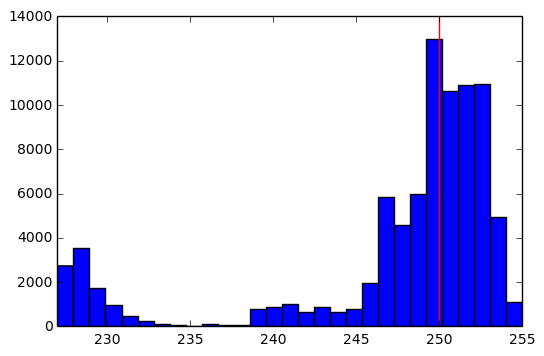

In [45]:
image_depth = cv2.bitwise_and(image_depth,image_depth,mask=255-mask_items)
pix_depth = image_depth.flatten()
pix_depth = pix_depth[pix_depth>0]
dmin, dmax = (np.min(pix_depth),np.max(pix_depth))
h,b = np.histogram(pix_depth,bins=dmax-dmin)
sh = np.cumsum(h)
b_high = [b_val for b_val,sh_val in zip(b,sh) if sh_val>sh[-1]/2]
dcut = int(b_high[0])
plt.hist(pix_depth,bins=dmax-dmin+1);
hmax = np.around(max(h)+1000,-3)
plt.plot([dcut,dcut],[0,hmax],'r-')
plt.axis([dmin,dmax,0,hmax]);

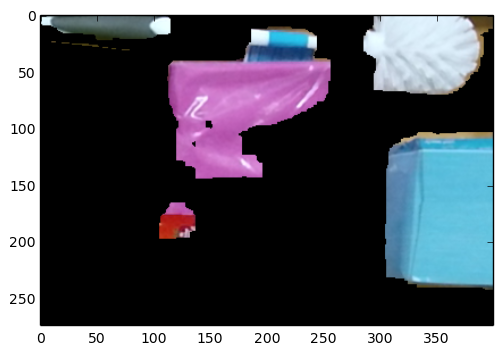

In [46]:
upper_bin = cv2.inRange(image_depth,int(dmin),dcut-1)
#kernel = np.ones((3,3),np.uint8)
#upper_bin = cv2.dilate(upper_bin,kernel,iterations = 3)
plt.imshow(cv2.bitwise_and(image_bin,image_bin,mask=upper_bin));

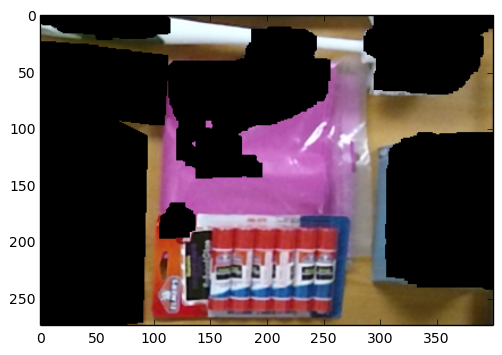

In [47]:
lower_bin = cv2.inRange(image_depth,dcut,int(dmax))
#kernel = np.ones((3,3),np.uint8)
#lower_bin = cv2.dilate(lower_bin,kernel,iterations = 3)
plt.imshow(cv2.bitwise_and(image_bin,image_bin,mask=lower_bin));

## Cluster colors in upper bin

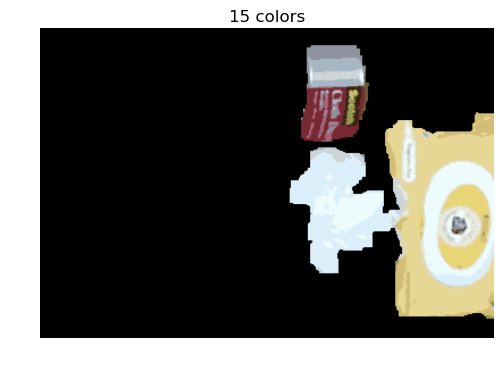

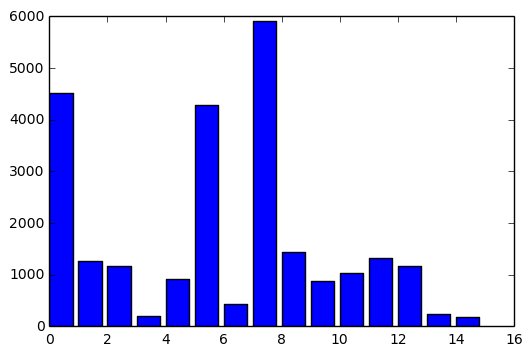

In [30]:
from utils import cluster_colors

positions_up, weights_up = cluster_colors(image_bin, upper_bin, items, n_cc=15)

In [31]:
pos_ok = [(p,w[0][1]) for p,w in zip(positions_up, weights_up) if len(w)==1]
pos_unkw = [(p,w) for p,w in zip(positions_up, weights_up) if len(w)>1]

## Cluster colors in lower bin

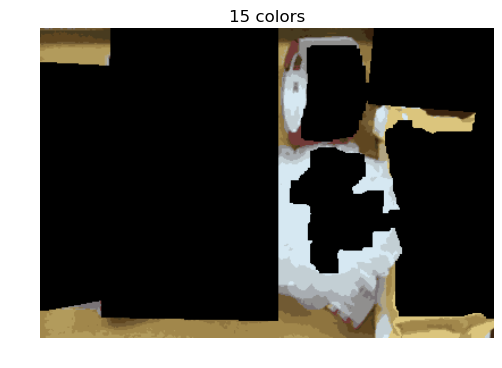

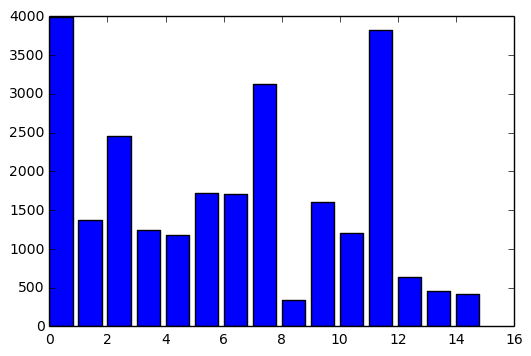

In [32]:
positions_low, weights_low = cluster_colors(image_bin, lower_bin, items, n_cc=15)

In [33]:
pos_ok += [(p,w[0][1]) for p,w in zip(positions_low, weights_low) if len(w)==1]
pos_unkw += [(p,w) for p,w in zip(positions_low, weights_low) if len(w)>1]

### Draw identified and unknown contours

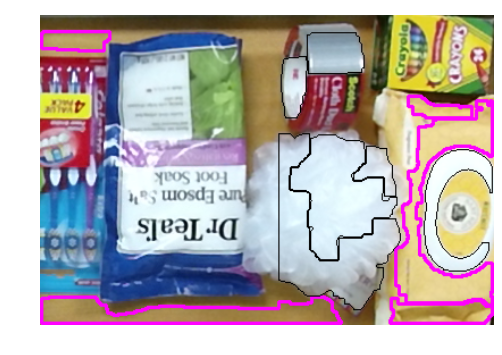

In [34]:
it_col = {'table_cloth':(255,0,255),'tissue_box':(0,255,255),'glue_sticks':(255,0,0),'toilet_brush':(255,255,0),
          'burts_bees_baby_wipes':(255,0,255),'bath_sponge':(0,255,255),'duct_tape':(255,0,0)}
image_disp = image_bin.copy()
mask_disp = upper_bin.copy()
for item in items:
    it_pos = [p for p,it in pos_ok if it==item]
    for cnt in it_pos:
        cv2.drawContours(image_disp,cnt,-1,it_col[item],2)
        cv2.drawContours(mask_disp,cnt,-1,(255,),-1)
for pos,w in pos_unkw:
    for cnt in pos:
        cv2.drawContours(image_disp,cnt,-1,(0,0,0),1)
        #cv2.drawContours(mask_disp,cnt,-1,(255,),-1)
plt.imshow(image_disp); plt.axis('off');

In [35]:
weights_up

[[(0.3673108002099183, 'burts_bees_baby_wipes')],
 [(0.20315875717707649, 'bath_sponge'),
  (0.18146955855392888, 'burts_bees_baby_wipes')],
 [(0.34096318218506177, 'duct_tape'),
  (0.7565547364229781, 'bath_sponge'),
  (0.46790119562131299, 'burts_bees_baby_wipes')],
 [],
 [(0.62626451465486799, 'burts_bees_baby_wipes')],
 [(0.31688939452454423, 'duct_tape'),
  (0.63127314879963325, 'bath_sponge'),
  (0.39041915523986714, 'burts_bees_baby_wipes')],
 [],
 []]

In [36]:
weights_low

[[(0.13966181745367628, 'duct_tape'),
  (0.30346627837839418, 'bath_sponge'),
  (0.18007448811111415, 'burts_bees_baby_wipes')],
 [(0.10279278080405843, 'burts_bees_baby_wipes')],
 [],
 []]